<a href="https://colab.research.google.com/github/skmerick/NYC_taxi_trip/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS
!pip install geopandas
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [2]:
# Trazendo os arquivos JSON com o pandas

df_2009 = pd.read_json("/content/drive/MyDrive/datasets/data-sample_data-nyctaxi-trips-2009-json_corrigido.json", lines=True)
df_2010 = pd.read_json("/content/drive/MyDrive/datasets/data-sample_data-nyctaxi-trips-2010-json_corrigido.json", lines=True)
df_2011 = pd.read_json("/content/drive/MyDrive/datasets/data-sample_data-nyctaxi-trips-2011-json_corrigido.json", lines=True)
df_2012 = pd.read_json("/content/drive/MyDrive/datasets/data-sample_data-nyctaxi-trips-2012-json_corrigido.json", lines=True)

In [3]:
# Checagem do SHAPE de cada dataframe.

dataframes = [df_2009, 
              df_2010, 
              df_2011, 
              df_2012]

for ano, df in zip(range(2009,2013), dataframes):
    print(ano, df.shape)

2009 (1000000, 17)
2010 (1000000, 17)
2011 (1000000, 17)
2012 (1000000, 17)


In [4]:
# Montando ABT para análise concatenando os 4 dataframes.

abt = pd.concat(dataframes).reset_index(drop=True)
abt.shape

(4000000, 17)

In [5]:
abt.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount
0,CMT,2009-04-21T18:51:11.767205+00:00,2009-04-21T18:57:09.433767+00:00,2,0.80,-74.004114,40.742950,NaN,NaN,-73.994712,40.747950,Cash,5.4,0.0,0.0,0.0,5.4
1,CMT,2009-01-13T07:40:07.639754+00:00,2009-01-13T07:50:36.386011+00:00,1,5.40,-73.996506,40.747784,NaN,NaN,-73.940449,40.792385,Cash,15.4,0.0,0.0,0.0,15.4
2,VTS,2009-01-06T19:30:44.142187+00:00,2009-01-06T19:43:09.908429+00:00,5,1.67,-73.951340,40.752070,NaN,NaN,-73.944535,40.768108,CASH,6.1,1.0,0.0,0.0,7.1
3,VTS,2009-09-24T08:28:09.004451+00:00,2009-09-24T08:41:56.739991+00:00,1,4.13,-74.001117,40.729128,NaN,NaN,-73.958122,40.721812,CASH,12.9,0.5,0.0,0.0,13.4
4,VTS,2009-10-29T05:50:39.214629+00:00,2009-10-29T05:57:22.880174+00:00,1,2.03,-73.976600,40.756873,NaN,NaN,-73.979757,40.776075,CASH,7.7,0.5,0.0,0.0,8.2


In [6]:
# Checagem de missing
abt.isnull().sum()

vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
rate_code             4000000
store_and_fwd_flag    3999752
dropoff_longitude           0
dropoff_latitude            0
payment_type                0
fare_amount                 0
surcharge                   0
tip_amount                  0
tolls_amount                0
total_amount                0
dtype: int64

In [7]:
# Eliminando colunas rate_code e store_and_fwd_flag pois ou não possuem dados por completo ou quase incompletos.

abt.dropna(axis=1, inplace=True)

abt.isnull().sum()

vendor_id            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

In [8]:
# Eliminando inconsistencias da coluna payment_type

abt['payment_type'].unique()

array(['Cash', 'CASH', 'Credit', 'CREDIT', 'No Charge', 'Dispute'],
      dtype=object)

In [9]:
abt['payment_type'] = abt['payment_type'].str.upper()
abt['payment_type'].unique()

array(['CASH', 'CREDIT', 'NO CHARGE', 'DISPUTE'], dtype=object)

In [10]:
# Extraindo dia, mês e ano, foi verificado que não houve dropoff após 00:00.

abt['pickup_datetime'] = pd.to_datetime(abt['pickup_datetime'])
abt['dropoff_datetime'] = pd.to_datetime(abt['dropoff_datetime'])

abt['day'] = pd.DatetimeIndex(abt['pickup_datetime']).day
abt['month'] = pd.DatetimeIndex(abt['dropoff_datetime']).month
abt['year'] = pd.DatetimeIndex(abt['dropoff_datetime']).year

abt.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,day,month,year
0,CMT,2009-04-21 18:51:11.767205+00:00,2009-04-21 18:57:09.433767+00:00,2,0.80,-74.004114,40.742950,-73.994712,40.747950,CASH,5.4,0.0,0.0,0.0,5.4,21,4,2009
1,CMT,2009-01-13 07:40:07.639754+00:00,2009-01-13 07:50:36.386011+00:00,1,5.40,-73.996506,40.747784,-73.940449,40.792385,CASH,15.4,0.0,0.0,0.0,15.4,13,1,2009
2,VTS,2009-01-06 19:30:44.142187+00:00,2009-01-06 19:43:09.908429+00:00,5,1.67,-73.951340,40.752070,-73.944535,40.768108,CASH,6.1,1.0,0.0,0.0,7.1,6,1,2009
3,VTS,2009-09-24 08:28:09.004451+00:00,2009-09-24 08:41:56.739991+00:00,1,4.13,-74.001117,40.729128,-73.958122,40.721812,CASH,12.9,0.5,0.0,0.0,13.4,24,9,2009
4,VTS,2009-10-29 05:50:39.214629+00:00,2009-10-29 05:57:22.880174+00:00,1,2.03,-73.976600,40.756873,-73.979757,40.776075,CASH,7.7,0.5,0.0,0.0,8.2,29,10,2009


In [11]:
# Calculando distância média percorrida por viagens com dois passageiros
(
    abt
    .query('passenger_count <= 2')['trip_distance']
    .mean()
)

2.6625269962030926

In [12]:
# Calculando o ranking dos maiores vendors em quantidade total de dinheiro arrecadado em cash.
(
    abt
    .query("payment_type == 'CASH'")
    .groupby('vendor_id')
    .agg(total_arrecadado = ('total_amount','sum'))
    .nlargest(5,'total_arrecadado')
)

,total_arrecadado
vendor_id,
CMT,14532005.00
VTS,13827166.08
DDS,2122999.72
TS,45.60


In [13]:
# Calculando o ranking dos maiores vendors em quantidade total de dinheiro arrecadado.
(
    abt
    .groupby('vendor_id')
    .agg(total_arrecadado = ('total_amount','sum'))
    .nlargest(5,'total_arrecadado')
)

,total_arrecadado
vendor_id,
CMT,19549084.28
VTS,19043434.00
DDS,2714901.72
TS,45.60


In [14]:
# Criando nova ABT auxiliar calculando o total arrecadado em dinheiro por mês e ano.
abt_aux=(
    abt
    .query("payment_type == 'CASH'")
    .groupby(['year','month'])
    .agg(total = ("total_amount","sum"))
    .reset_index()
)
abt_aux

,year,month,total
0,2009,1,627114.48
1,2009,2,625200.95
2,2009,3,696450.12
3,2009,4,667370.48
4,2009,5,698447.24
5,2009,6,669458.95
6,2009,7,697602.50
7,2009,8,697113.99
8,2009,9,671717.14
9,2009,10,695400.53


In [15]:
# Resposicionando dados do ABT auxiliar para melhor visualização do histograma.

abt_hist = pd.DataFrame(columns=["2009","2010","2011","2012"],
                        index=['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']).reset_index().rename(columns={'index': 'Month'})
                        
abt_hist['2009'][0:12] = abt_aux['total'][0:12]
abt_hist['2010'][0:12] = abt_aux['total'][12:24]
abt_hist['2011'][0:11] = abt_aux['total'][24:35]
abt_hist['2012'][0:10] = abt_aux['total'][35:45]
abt_hist.fillna(value=0)

,Month,2009,2010,2011,2012
0,Jan,627114.48,622276.86,520773.54,759541.39
1,Fev,625200.95,624851.63,667560.71,735049.92
2,Mar,696450.12,694967.72,734782.24,783624.82
3,Abr,667370.48,671595.01,714882.15,764005.61
4,Mai,698447.24,690536.33,736883.66,789553.75
5,Jun,669458.95,670173.03,711531.91,760229.17
6,Jul,697602.50,690734.69,740967.53,791237.59
7,Ago,697113.99,688324.04,745916.43,785463.51
8,Set,671717.14,665024.55,715324.75,766520.46
9,Out,695400.53,692724.30,740265.84,685327.88


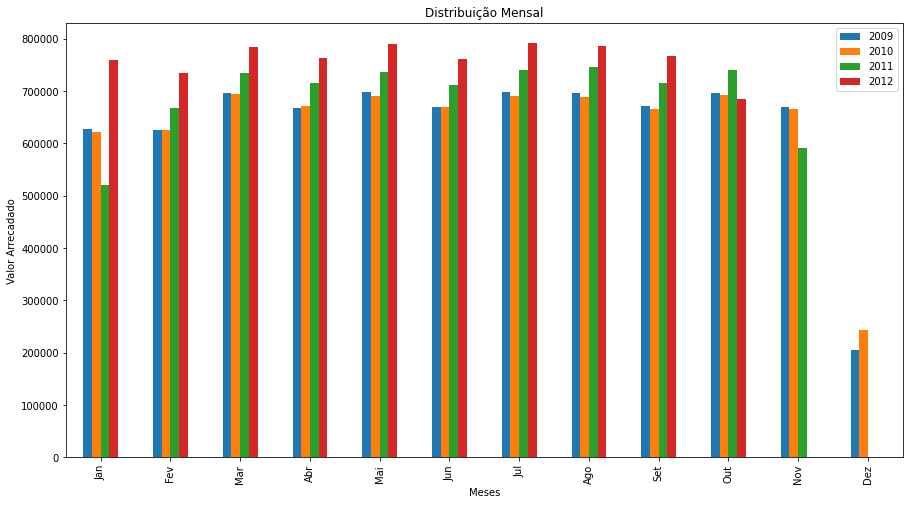

In [16]:
# Histograma da distribuição por mês e ano, do valor total arrecadado em dinheiro.

abt_hist.plot(
    kind="bar", 
    figsize=(15,8), 
    x='Month',
    xlabel = 'Meses',
    ylabel = 'Valor Arrecadado',
    title = 'Distribuição Mensal'
)

In [17]:
# Separando os últimos 3 meses de 2012 disponiveis.

abt_tip=(
    abt
    .query("year == 2012 & month > 7")
    .assign(data_completa = pd.to_datetime(abt['dropoff_datetime'].dt.date))
    .filter(['data_completa', 'tip_amount'])
    .groupby('data_completa')
    .sum()
    .reset_index()
)

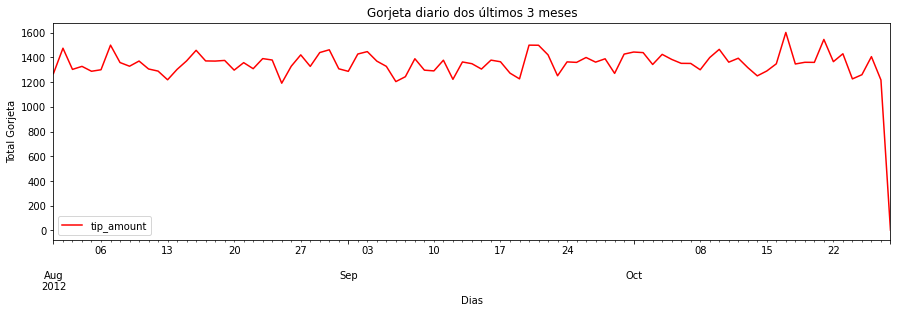

In [18]:
abt_tip.plot( 
    figsize=(15,4), 
    x='data_completa',
    xlabel = 'Dias',
    ylabel = 'Total Gorjeta',
    title = 'Gorjeta diario dos últimos 3 meses',
    color='red'
)

In [19]:
# Calculando o tempo médio de corridas nos finais de semana.
(
    abt
    .assign(data_completa = pd.to_datetime(abt['dropoff_datetime'].dt.date))
    .assign(weekday = lambda x : x['data_completa'].dt.weekday)
    .query("weekday >= 5")
    .assign(tempo_corrida = lambda x: x['dropoff_datetime'] - x['pickup_datetime'])['tempo_corrida']
    .mean()
)

Timedelta('0 days 00:08:44.787484850')

In [20]:
nyc_map = gpd.read_file('/content/drive/MyDrive/datasets/NYC/geo_export_ae0a9112-5e31-4400-a339-fa2295d88850.shp')

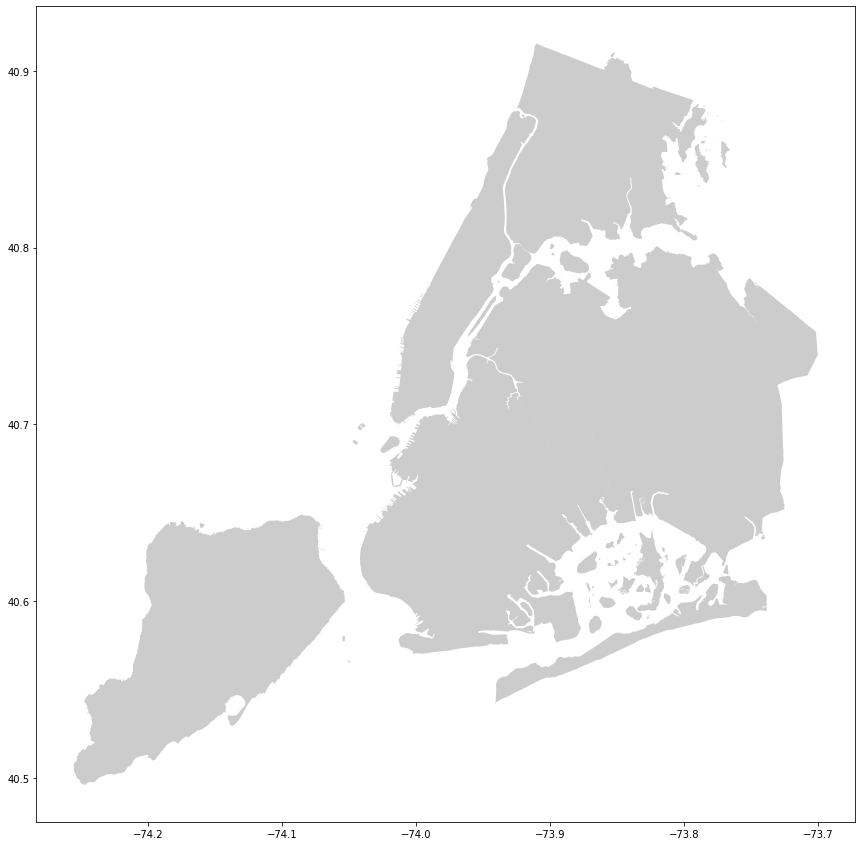

In [21]:
# Mapa da cidade de Nova York

fig, ax= plt.subplots(figsize=(15,15))
nyc_map.plot(ax = ax, alpha = 0.4, color='grey')

In [22]:
abt_map=(
    abt
    .query('year == 2010 & pickup_longitude < -73.7 & pickup_longitude > -74.3 & pickup_latitude < 41 & pickup_latitude > 40.4 & dropoff_longitude < -73.7 & dropoff_longitude > -74.3 & dropoff_latitude < 41 & dropoff_latitude > 40.4')
    .filter(["pickup_latitude", "pickup_longitude", "dropoff_latitude","dropoff_longitude"])    
)

In [23]:
geometry_pickup = [Point(xy) for xy in zip(abt_map['pickup_longitude'],
                                           abt_map['pickup_latitude'])]
geometry_dropoff = [Point(xy) for xy in zip(abt_map['dropoff_longitude'],
                                            abt_map['dropoff_latitude'])]

In [24]:
crs = {'init': 'epsg:4326'}
geo_pick = gpd.GeoDataFrame( crs=crs, geometry=geometry_pickup)
geo_drop = gpd.GeoDataFrame( crs=crs, geometry=geometry_dropoff)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


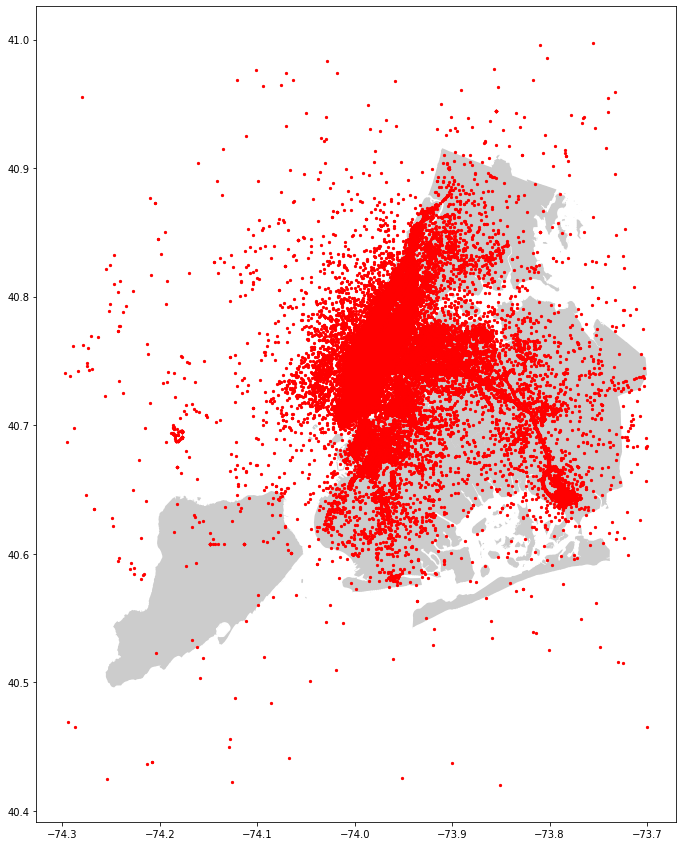

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, alpha = 0.4, color="grey")
geo_pick.plot(ax = ax, markersize=5, color = "red", marker = "o", label="pickup")

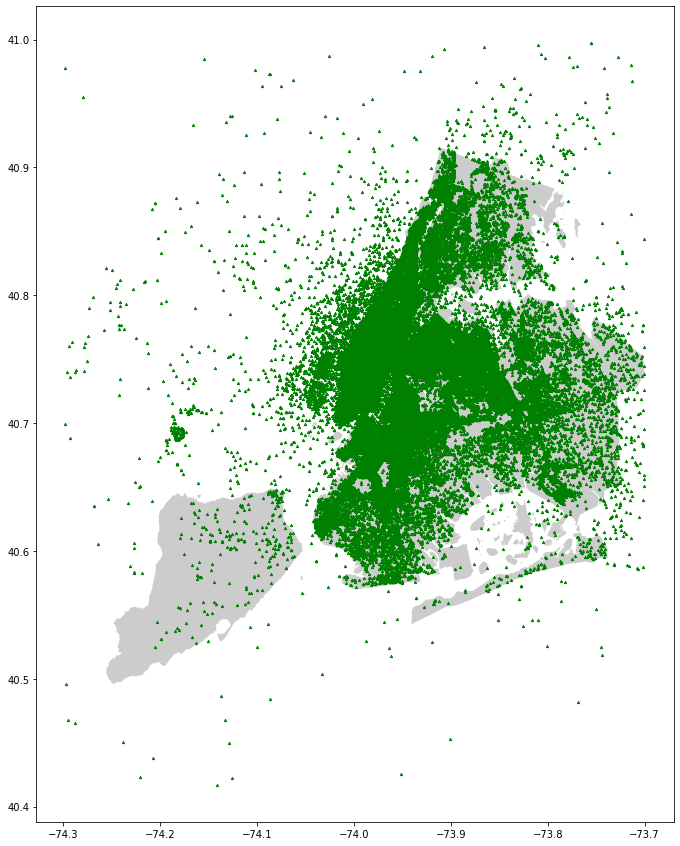

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, alpha = 0.4, color="grey")
geo_drop.plot(ax = ax, markersize=5, color = "green", marker = "^", label="dropoff")